In [10]:
import keras
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import misc
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
import pickle
import pandas as pd
%matplotlib inline

In [11]:
# load images to array
def load_img(filename):
    img = misc.imresize(misc.imread(filename),(224, 224, 3)) 
    return img/255

# get feature list of images
def featurize(trash_class):
    feature = []
    file_names = os.listdir(trash_class)
    print(len(file_names))
    for fname in file_names:
        img = load_img(os.path.join(trash_class+'/', fname)).reshape(1,224,224,3)
        #print(img)
        prediction = vgg_16.predict(img)
        #print(len(prediction))
        feature = np.append(feature, prediction)
    return feature.reshape(int(len(feature)/490), 490)

In [12]:
VGG16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [13]:
#VGG16.summary()

In [14]:
vgg_16 = Sequential()
for layer in VGG16.layers:
    vgg_16.add(layer)

In [15]:
vgg_16.add(Dense(32, input_shape=(None, 7, 7, 512)))
vgg_16.add(Dense(10, input_shape=(None, 7, 7, 32)))
vgg_16.add(Flatten())

In [16]:
#vgg_16.summary()

In [92]:
cardboard = featurize('cardboard')

403


In [93]:
glass = featurize('glass')

501


In [95]:
metal = featurize('metal')

410


In [96]:
paper = featurize('paper')

594


In [98]:
plastic = featurize('plastic')

482


In [99]:
trash = featurize('trash')

137


In [100]:
classes = ['c', 'g', 'm', 'p', 'pl', 't']
samples = [len(cardboard), len(glass), len(metal), len(paper), len(plastic), len(trash)]
labels = [] 
for i in np.arange(6):
    print(i)
    labels = np.append(labels, [classes[i]]*samples[i])

0
1
2
3
4
5


In [101]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(classes)
labels = le.transform(labels) 

In [102]:
len(labels)

2527

In [103]:
df = pd.DataFrame(cardboard)

In [104]:
df = df.append(pd.DataFrame(glass))
df = df.append(pd.DataFrame(metal))
df = df.append(pd.DataFrame(paper))
df = df.append(pd.DataFrame(plastic))
df = df.append(pd.DataFrame(trash))

In [105]:
df['labels'] = labels

In [106]:
df.shape

(2527, 491)

In [107]:
df.to_csv('featurized.csv')

In [108]:
df = pd.read_csv('featurized.csv')

In [109]:
from sklearn.model_selection import train_test_split

In [110]:
train, test = train_test_split(df, test_size = .10)

In [111]:
train_y = train['labels']
train_x = train.drop('labels', 1)
test_y = test['labels']
test_x = test.drop('labels', 1)

In [112]:
train_x.shape

(2274, 491)

In [113]:
from sklearn.svm import LinearSVC

In [114]:
svc = LinearSVC(multi_class='crammer_singer')

In [115]:
svc.fit(train_x, train_y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='crammer_singer', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)

In [116]:
svc.score(train_x,train_y)

0.69393139841688656

In [117]:
svc.score(test_x,test_y)

0.41501976284584979

In [118]:
from sklearn.linear_model import LogisticRegression

In [119]:
LR = LogisticRegression(solver='lbfgs', multi_class='multinomial')

In [120]:
LR.fit(train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [121]:
LR.score(train_x,train_y)

0.55233069481090591

In [122]:
LR.score(test_x,test_y)

0.52569169960474305

In [123]:
from sklearn.tree import DecisionTreeClassifier

In [124]:
DT = DecisionTreeClassifier()

In [125]:
DT.fit(train_x, train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [126]:
DT.score(train_x, train_y)

1.0

In [127]:
DT.score(test_x, test_y)

0.39920948616600793

In [128]:
from sklearn.ensemble import RandomForestClassifier

In [129]:
RF = RandomForestClassifier()

In [130]:
RF.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [131]:
RF.score(train_x, train_y)

0.99472295514511877

In [132]:
RF.score(test_x, test_y)

0.4743083003952569

In [133]:
models = [svc, LR, DT, RF]
train_scores = []
validation_scores = []



for model in models:
    train_scores = np.append(train_scores, model.score(train_x, train_y))
    validation_scores = np.append(validation_scores, model.score(test_x, test_y))

print(train_scores,
      validation_scores)

[ 0.6939314   0.55233069  1.          0.99472296] [ 0.41501976  0.5256917   0.39920949  0.4743083 ]


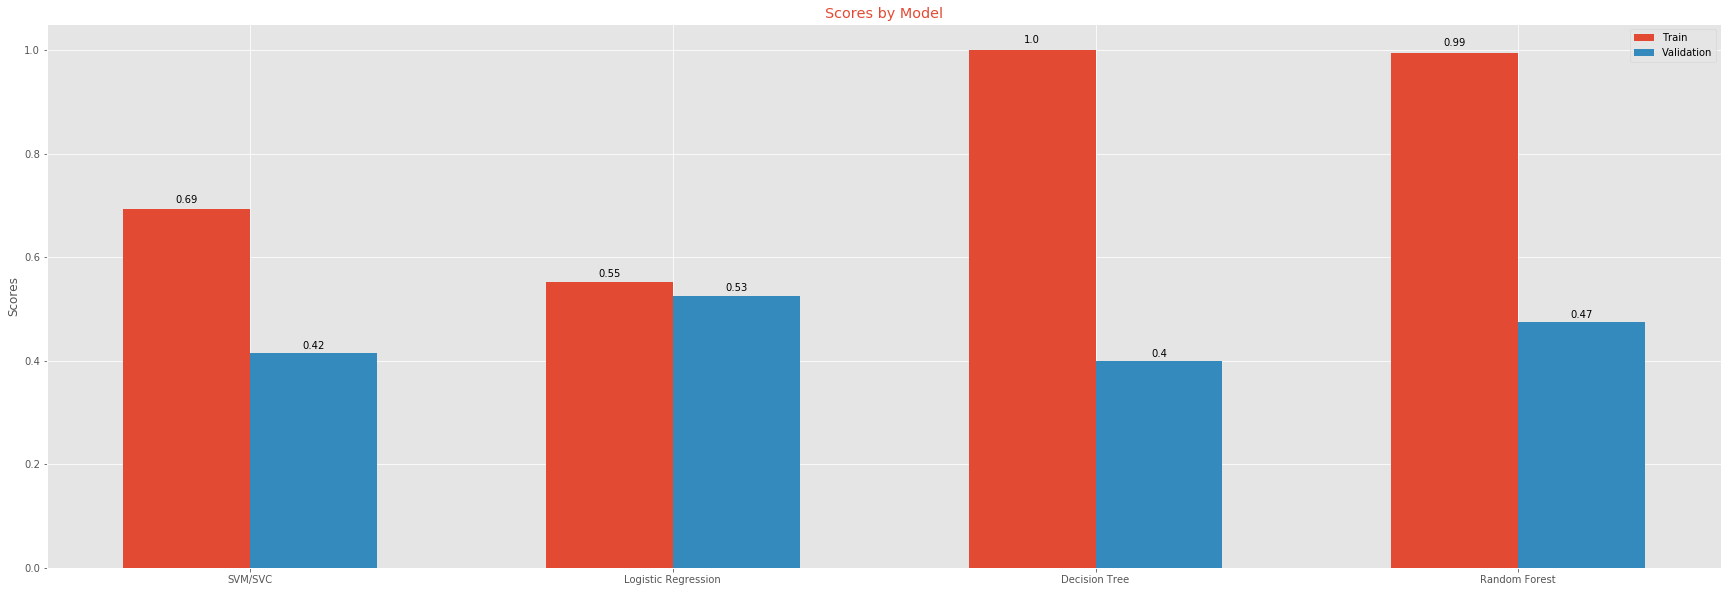

In [136]:
plt.style.use('ggplot')
N = 4

ind = np.arange(N)  # the x locations for the groups
width = 0.30       # the width of the bars

fig, ax = plt.subplots(figsize=(30, 10))
rects1 = ax.bar(ind, train_scores, width)
rects2 = ax.bar(ind + width, validation_scores, width)


# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Scores by Model', color='C0')
ax.set_xticks(ind + width/2)
ax.set_xticklabels(('SVM/SVC', 'Logistic Regression', 'Decision Tree', 'Random Forest'))

ax.legend((rects1[0], rects2[0]), ('Train', 'Validation'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                round(height, 2),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()